In [3]:
%run setup.py
%config IPython.matplotlib.backend = "retina"

# HeB

In [12]:
def plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle, panels):
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_edge(xobs, yobs, xedge_obs, yedge_obs, tck_obs, tp_obs, diagram=diagram, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model)
    obj_obs = distfit(hdist_obs, hist_model, bins=obj_obs.bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_edge(xpdv, ypdv, xedge_pdv, yedge_pdv, tck_pdv, tp_pdv, diagram=diagram, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]

    # tied to model6
    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot
    fig = plt.figure(figsize=mnras_size())
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    obj_obs.plot_hist(ax=axes[0], histkwargs={"color":"red","linewidth":2.0,"label":"Kepler", "zorder":100})
    obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black","linewidth":0.5, "linestyle":"--", "zorder":100})
    # obj_pdv.plot_hist(ax=axes[0], histkwargs={"color":"green", "label":"Galaxia initial model"})


    # plot three different combinations
    scatters = scatters
    colors = sns.cubehelix_palette(2, start=2.8, rot=0., dark=0.25, light=.60, reverse=True)
    # linestyles = ['densly dashdotted', 'dashdotted', 'loosely dashdotted']
    linestyles = [(0,(3,1,1,1)), (0,(3,1,1,1,1,1))]#, (0,(3,1,1,1,1,1,1,1))]
    # colors = sns.dark_palette("navy", n_colors=4, reverse=True)#sns.dark_palette("blue", 4)[::-1]
    for i in range(len(scatters)):
        # calculate best fitted results
        para_fit = [0, scatters[i]]
        yfit, hdist, number_reduction_factor = model(para_fit)
        Ndata = hdist.shape[0]
        idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

        if distance=="vertical":
            xdata = xpdv
            ydata = ypdv + fp*para_fit[1]
        else:
            xdata = xpdv + fp*para_fit[1]
            ydata = ypdv

        xfit, yfit = xdata[idx], ydata[idx]
        hdist_fit, xfit, yfit = distance_to_edge(xfit, yfit, xedge_pdv, yedge_pdv, tck_pdv, tp_pdv, diagram=diagram, distance=distance)
        hdist_fit = hdist_fit + para_fit[0]

        obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
        obj_fit.fit(ifmcmc=False)
        str_scatter = "{:0.0f}\%".format(scatters[i]*100)
        label = "Galaxia $\\sigma_{"+variable+"}="+str_scatter+"$" #"$r_{"+variable+"}=0$, 
        axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":colors[i], "label":label, "linewidth":2.})#"linestyle":linestyles[i]


    # axes[0].grid(True)
    axes[0].set_ylim(0., obj_obs.histy.max()*1.5)
    axes[0].set_xlabel(xtitle)
    axes[0].set_ylabel("Counts")
    axes[0].legend()
    # fill weighted region
    xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
    lr = xmax_ - xmin_
    axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
    axes[0].set_xlim(xmin_-lr*1.0, xmax_+lr*1.3)
    axes[0].text(0.05, 0.9, panels, transform=axes[0].transAxes)

    # plt.show()
    plt.tight_layout()
    plt.savefig(overleaf_path+filename)
    # plt.close()


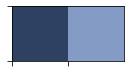

In [8]:
sns.palplot(sns.cubehelix_palette(2, start=2.8, rot=0., dark=0.25, light=.60, reverse=True))

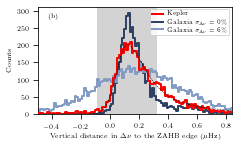

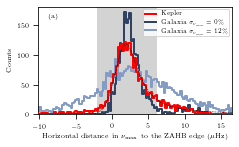

In [13]:
yu = np.load(work_path+'sample/heb/yu/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/yu/tnu_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/heb/yu/nike_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["numax"], yu["dnu"]
xedge_obs, yedge_obs = edge[:,0], edge[:,1]

pdv = np.load(work_path+'sample/heb/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/padova/tnu_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/heb/padova/nike_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["numax"], pdv["dnu"]
xedge_pdv, yedge_pdv = edge[:,0], edge[:,1]

from lib.histdist import distance_to_edge, distfit, model6, reduce_samples
diagram = "tnu"
hist_model = model6()


distance = "vertical"
variable = "\Delta\\nu"
filename = "hist_heb_dnu.pdf"
xtitle = "Vertical distance in $\\Delta\\nu$ to the ZAHB edge ($\\mu$Hz)"
# scatters = [0, 0.02, 0.06]
scatters = [0, 0.06]
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle, "(b)")

distance = "horizontal"
variable = "\\nu_{\\rm max}"
filename = "hist_heb_numax.pdf"
xtitle = "Horizontal distance in $\\nu_{\\rm max}$ to the ZAHB edge ($\\mu$Hz)"
# scatters = [0, 0.04, 0.12]
scatters = [0, 0.12]
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle, "(a)")

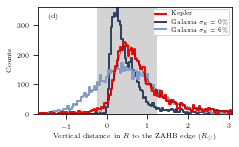

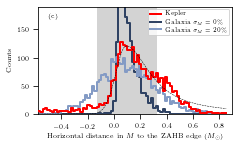

In [14]:
yu = np.load(work_path+'sample/heb/yu/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/yu/mr_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/heb/yu/mr_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["mass"], yu["radius"]
xedge_obs, yedge_obs = edge[:,0], edge[:,1]

pdv = np.load(work_path+'sample/heb/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/padova/mr_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/heb/padova/mr_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["mass"], pdv["radius"]
xedge_pdv, yedge_pdv = edge[:,0], edge[:,1]

from lib.histdist import distance_to_edge, distfit, model6, reduce_samples
diagram = "mr"
hist_model = model6()


distance = "vertical"
variable = "R"
filename = "hist_heb_radius.pdf"
# scatters = [0, 0.03, 0.06]
scatters = [0, 0.06]
xtitle = "Vertical distance in $R$ to the ZAHB edge ($R_{\odot}$)"
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle, "(d)")

distance = "horizontal"
variable = "M"
filename = "hist_heb_mass.pdf"
# scatters = [0, 0.07, 0.20]
scatters = [0, 0.20]
xtitle = "Horizontal distance in $M$ to the ZAHB edge ($M_{\odot}$)"
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle, "(c)")

# RGB

In [8]:
def plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, filename, scatters, xtitle, panels):
    
    if variable =='\Delta\\nu':
        bins = np.arange(-3, 3, 0.2)
    elif variable == '\\nu_{\\rm max}':
        bins = np.arange(-33, 33, 2.0)
    elif variable == 'M':
        bins = np.arange(-0.8, 0.8, 0.05)
    else:
        bins = np.arange(-3.0, 3.0, 0.2)
    
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model, bins=bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]

    # tied to model6
    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    if variable == 'M': sigma, x0 = 0.4/3., 0.
    if variable == 'R': sigma, x0 = 2.0/3., 0.05
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True

    
    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot
    fig = plt.figure(figsize=mnras_size())
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    obj_obs.plot_hist(ax=axes[0], histkwargs={"color":"red", "linewidth":2.0, "label":"Kepler", "zorder":100})
    obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black", "linewidth":0.5, "linestyle":"--", "zorder":100})
#     if variable in ['\Delta\\nu', '\\nu_{\\rm max}']:
#         obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black", "linewidth":0.5, "linestyle":"--", "zorder":100})
#     else:
#         if variable == 'M':
#             fitbins = np.arange(-0.4, 0.4, 0.05)
#         if variable == 'R':
#             fitbins = np.arange(-2., 2., 0.2)
            
#         obj = distfit(hdist_obs, hist_model, bins=fitbins)
#         obj.fit(ifmcmc=False)
    
#         obj_obs.plot_fit(ax=axes[0], theta=obj.para_fit, fitkwargs={"color":"black", "linewidth":0.5,
#                                                                     "linestyle":"--", "zorder":100})


    # plot three different combinations
    scatters = scatters
    colors = sns.cubehelix_palette(2, start=2.8, rot=0., dark=0.25, light=.60, reverse=True)
    # linestyles = ['densly dashdotted', 'dashdotted', 'loosely dashdotted']
    linestyles = [(0,(3,1,1,1)), (0,(3,1,1,1,1,1))]#, (0,(3,1,1,1,1,1,1,1))]

    for i in range(len(scatters)):
        # calculate best fitted results
        para_fit = [0, scatters[i]]
        yfit, hdist, number_reduction_factor = model(para_fit)
        Ndata = hdist.shape[0]
        idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

        if distance=="vertical":
            xdata = xpdv
            ydata = ypdv + fp*para_fit[1]
        else:
            xdata = xpdv + fp*para_fit[1]
            ydata = ypdv

        xfit, yfit = xdata[idx], ydata[idx]
        hdist_fit, xfit, yfit = distance_to_bump(xfit, yfit, bump_pdv, distance=distance)
        hdist_fit = hdist_fit + para_fit[0]

        obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
        obj_fit.fit(ifmcmc=False)
        str_scatter = "{:0.0f}\%".format(scatters[i]*100)
        label = "Galaxia $\\sigma_{"+variable+"}="+str_scatter+"$" #"$r_{"+variable+"}=0$, 
        axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":colors[i], "label":label, 
                                                      "linewidth":2.0})#"linestyle":linestyles[i]


    # axes[0].grid(True)
    axes[0].set_ylim(0., obj_obs.histy.max()*1.5)
    axes[0].set_xlabel(xtitle)
    axes[0].set_ylabel("Counts")
    axes[0].legend(loc='upper right')
    # fill weighted region
    xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
    lr = xmax_ - xmin_
    axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
    axes[0].set_xlim(obj_obs.histx.min(), obj_obs.histx.max())
    axes[0].text(0.05, 0.9, panels, transform=axes[0].transAxes)
    
    # plt.show()
    plt.tight_layout()
    plt.savefig(overleaf_path+filename)
    # plt.close()


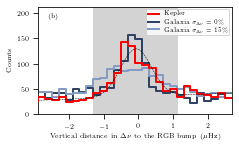

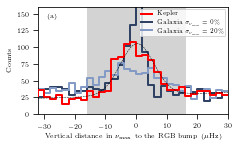

In [12]:
yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/dnu_bump.npy')
xobs, yobs = yu["teff"], yu["dnu"]

pdv = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/mist/dnu_bump.npy')
xpdv, ypdv = pdv["teff"], pdv["dnu"]

from lib.histdist import distance_to_bump, distfit, model7, reduce_samples
diagram = "tnu"
hist_model = model7()


distance = "vertical"
variable = "\Delta\\nu"
filename = "hist_rgb_dnu.pdf"
xtitle = "Vertical distance in $\Delta\\nu$ to the RGB bump ($\\mu$Hz)"
# scatters = [0, 0.07, 0.15]
scatters = [0, 0.15]
plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, filename, scatters, xtitle, "(b)")


bump_obs = np.load(work_path+'sample/rgb/yu/numax_bump.npy')
xobs, yobs = yu["teff"], yu["numax"]
bump_pdv = np.load(work_path+'sample/rgb/mist/numax_bump.npy')
xpdv, ypdv = pdv["teff"], pdv["numax"]
distance = "vertical"
variable = "\\nu_{\\rm max}"
filename = "hist_rgb_numax.pdf"
xtitle = "Vertical distance in $\\nu_{\\rm max}$ to the RGB bump ($\\mu$Hz)"
# scatters = [0, 0.1, 0.2]
scatters = [0, 0.2]
plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, filename, scatters, xtitle, "(a)")


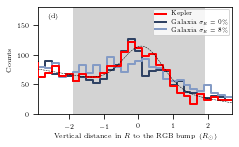

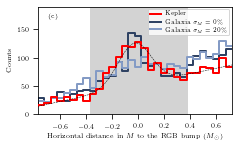

In [13]:
yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/mr_bump.npy')
xobs, yobs = yu["mass"], yu["radius"]

pdv = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/mist/mr_bump.npy')
xpdv, ypdv = pdv["mass"], pdv["radius"]

from lib.histdist import distance_to_bump, distfit, model7, reduce_samples
diagram = "mr"
hist_model = model7()


distance = "vertical"
variable = "R"
filename = "hist_rgb_radius.pdf"
xtitle = "Vertical distance in $R$ to the RGB bump ($R_{\odot}$)"
# scatters = [0, 0.04, 0.08]
scatters = [0, 0.08]
plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, filename, scatters, xtitle, "(d)")


distance = "horizontal"
variable = "M"
filename = "hist_rgb_mass.pdf"
xtitle = "Horizontal distance in $M$ to the RGB bump ($M_{\odot}$)"
# scatters = [0, 0.07, 0.2]
scatters = [0, 0.2]
plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, filename, scatters, xtitle, "(c)")
